In [4]:
!pip install finlab_crypto > log.txt #--ignore-installed llvmlite
import finlab_crypto
finlab_crypto.setup()

/home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [22]:
ohlcv = finlab_crypto.crawler.get_all_binance('BTCUSDT', '1h')
import talib
import numpy as np
from finlab_crypto import Strategy

@Strategy(timeperiod=14,sma1=20,sma2=60,n=20,m=40)
def sar_strategy(ohlcv):
  close = ohlcv.close
  sma20 = close.rolling(sar_strategy.sma1).mean()
  sma60 = close.rolling(sar_strategy.sma2).mean()
  median = ohlcv.close.rolling(sar_strategy.n).median()
  p1 = ohlcv.close > median
  p2 = ohlcv.close.shift() > median
  mmi = (p1 & p2).astype(int).rolling(sar_strategy.m).mean()
  entries = (sma20 > sma60) & (sma20.shift() < sma60.shift()) & (mmi > 0.5)
  exits = (sma20 < sma60) & (sma20.shift() > sma60.shift()) #& (mmi < 0.5)
  figures = {'overlaps': {'sma20': sma20, 'sma60': sma60}}
  return entries, exits, figures

variables = {'sma1': 15,
             'sma2': 75,
             'n':14,
             'm':2
             
             }

sar_strategy.backtest(ohlcv, variables=variables , freq='1h', plot=True)

All caught up..!


/home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ubuntu/tensorflow/anaconda3/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


<AxesSubplot:xlabel='Date'>

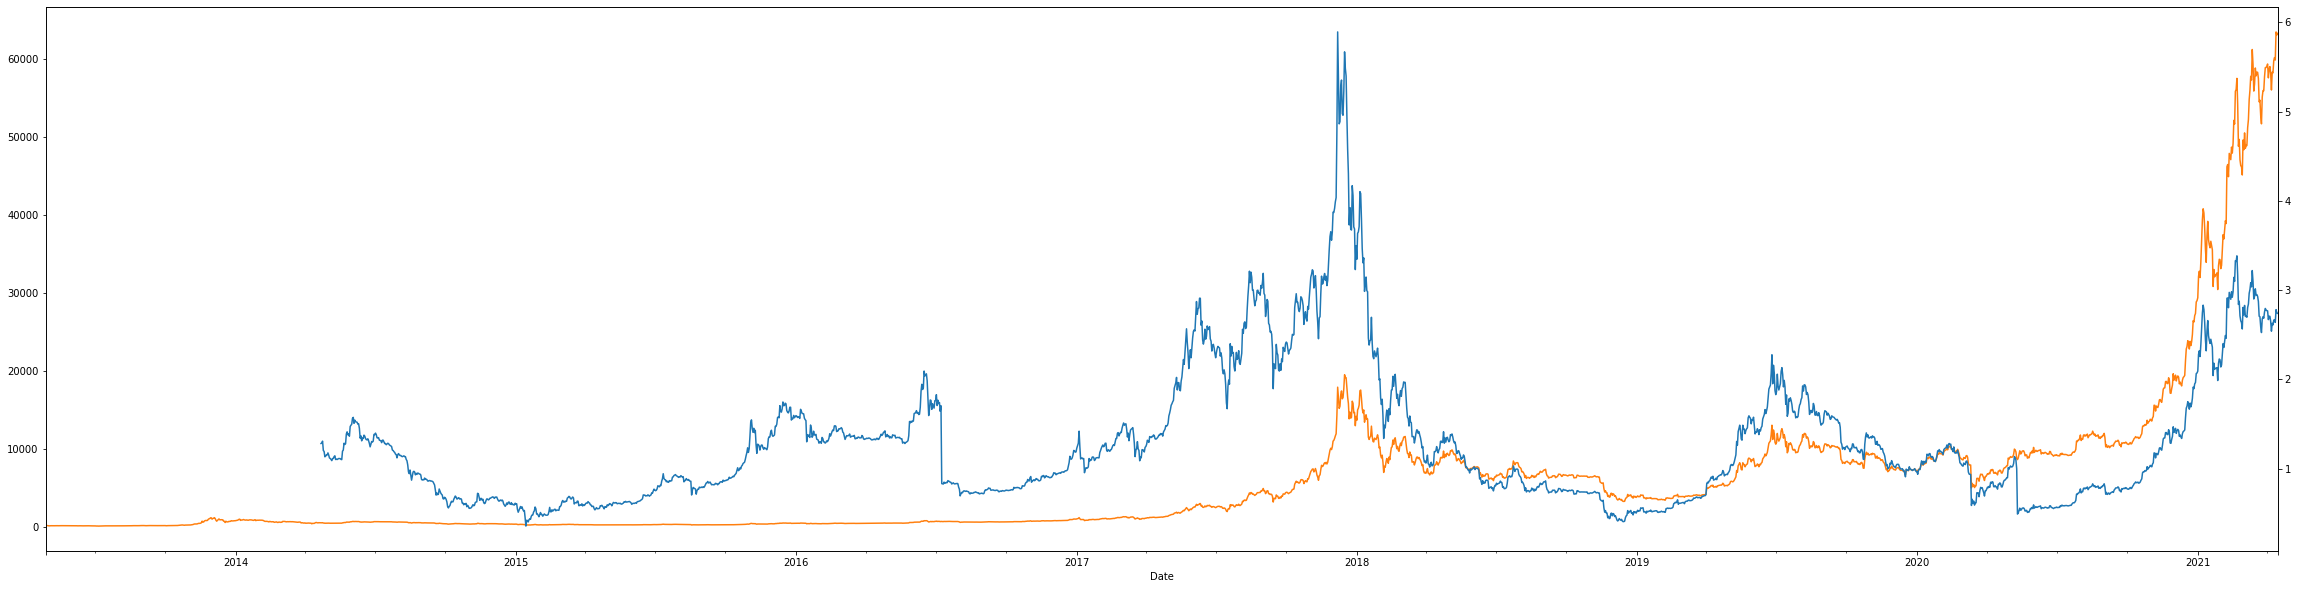

In [9]:
!pip install cryptocmd > log.txt

from cryptocmd import CmcScraper
scraper = CmcScraper("btc")
scraper.export("csv", name="btc_all_time")

import pandas as pd

ohlcv = pd.read_csv('btc_all_time.csv', index_col='Date')
ohlcv.columns = ohlcv.columns.str.lower()
ohlcv.index = pd.to_datetime(ohlcv.index.str[-4:] + '-' + ohlcv.index.str[3:5] + '-' + ohlcv.index.str[:2])
ohlcv = ohlcv.sort_index()

import pandas as pd

dates = {'2012-11-28': 25, '2016-7-9': 12.5, '2020-5-11':6.25, '2024-5-11':3.125}
reward = pd.Series(dates)
reward.index = pd.to_datetime(reward.index)
reward = reward.reindex(ohlcv.index, method='ffill')



# bitcoin design rule: generate 900 blocks every day
daily_value_mined = (reward * ohlcv.close * 900)
# normalize,the data range is too different
daily_value_mined_avg = daily_value_mined.rolling(360).mean()

puell_multiple = (daily_value_mined / daily_value_mined_avg)

from matplotlib import pyplot as plt
plt.figure(figsize=(40,10))


puell_multiple.plot(secondary_y=True)
ohlcv.close.plot()
#puell_multiple.plot()